In [76]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [42]:
path = '/Users/berkaybakac/Desktop/Facial_Recognition_Dataset/'
try:
    files = os.listdir(path)
    print(files)
    data = pd.read_csv(os.path.join(path, 'icml_face_data.csv'))
    data = data.dropna()  # Eksik verileri atma
    print(data.head())
except Exception as e:
    print(f"Error: {e}")



['fer2013', '.DS_Store', 'icml_face_data.csv', 'test.csv', 'train.csv', 'example_submission.csv']
   emotion     Usage                                             pixels
0        0  Training  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  Training  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  Training  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  Training  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  Training  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [43]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()
    
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

In [44]:
data[' Usage'].value_counts()

 Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [45]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [46]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [47]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [48]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

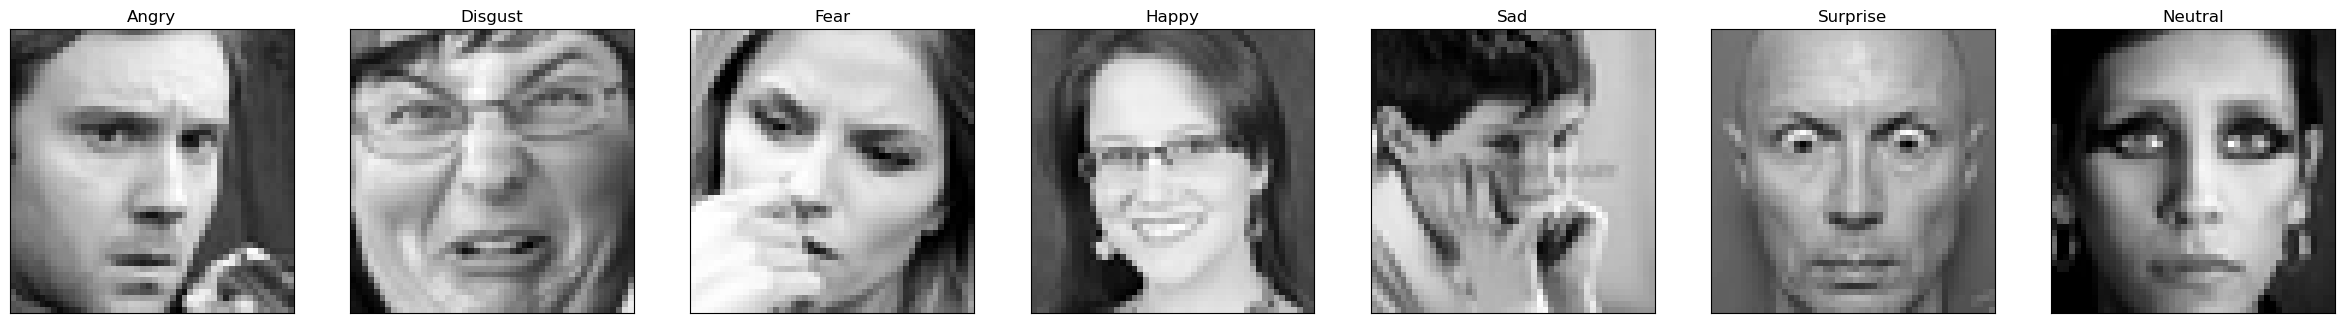

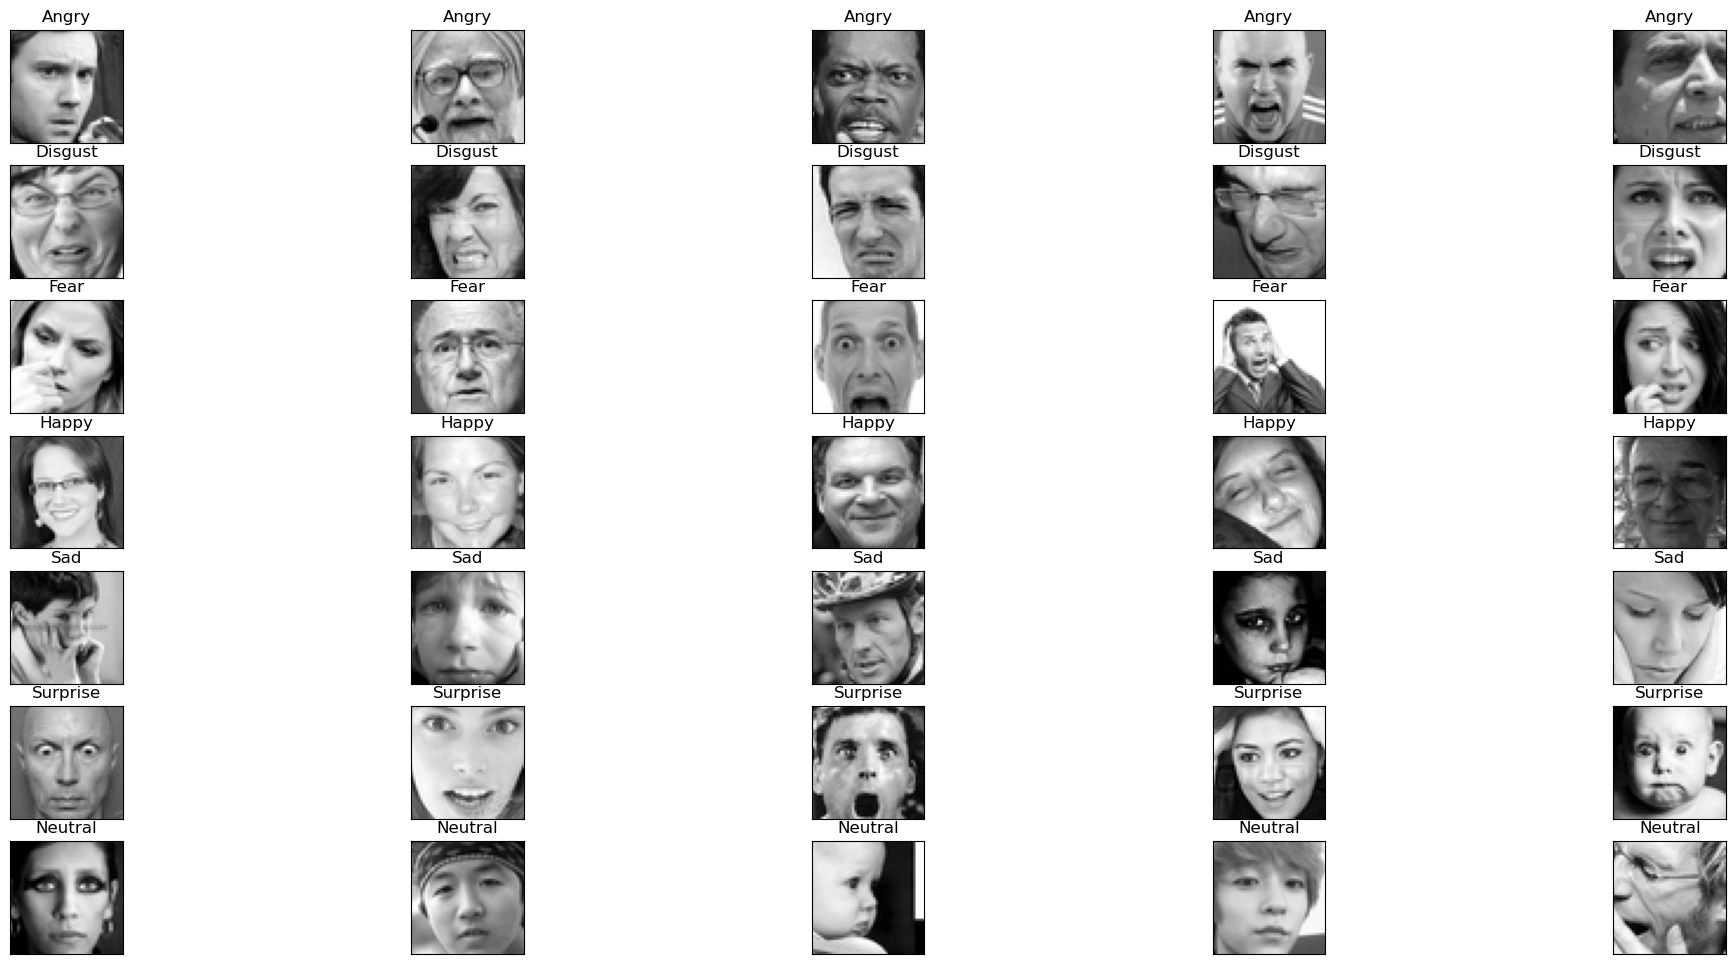

In [49]:
def plot_all_emotions(data, train_images, train_labels, emotions):
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace=.2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion'] == i].index[0]
        axs[i].imshow(train_images[idx], cmap='gray')
        axs[i].set_title(emotions[i])
        axs[i].set_xticks([])
        axs[i].set_yticks([])

def plot_examples(data, train_images, train_labels, emotions, labels):
    fig, axs = plt.subplots(len(labels), 5, figsize=(25, 12))
    fig.subplots_adjust(hspace=.2, wspace=.2)
    axs = axs.ravel()
    for label in labels:
        for i in range(5):
            idx = data[data['emotion'] == label].index[i]
            axs[label*5 + i].imshow(train_images[idx], cmap='gray')
            axs[label*5 + i].set_title(emotions[label])
            axs[label*5 + i].set_xticks([])
            axs[label*5 + i].set_yticks([])

# Tüm duyguların örneklerini görselleştirmek için
plot_all_emotions(data, train_images, train_labels, emotions)

# Belirli duyguların örneklerini görselleştirmek için
labels_to_plot = [0, 1, 2, 3, 4, 5, 6]  # Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral
plot_examples(data, train_images, train_labels, emotions, labels_to_plot)

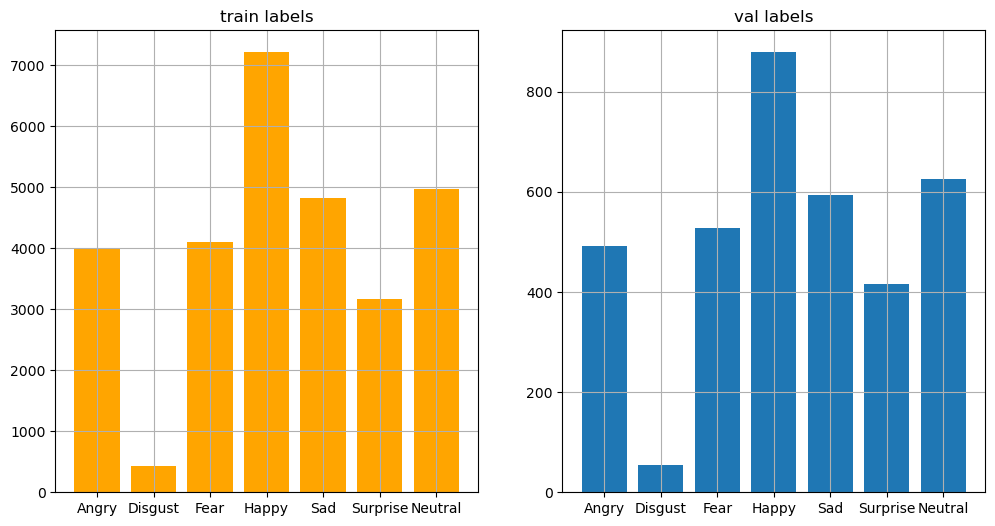

In [50]:
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

In [51]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

In [52]:
# Gelişmiş CNN modeli tanımlama
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1), kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer=legacy_optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 23, 23, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 21, 21, 64)      

In [53]:
# Callback'ler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Modeli eğitme
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight=class_weight,
                    epochs=50,
                    batch_size=64,
                    callbacks=[reduce_lr, early_stopping])

# Modeli değerlendirme
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

# Tahminler
pred_test_labels = model.predict(test_images)

Epoch 1/50
449/449 [==============================] - 31s 69ms/step - loss: 3.4422 - accuracy: 0.2000 - val_loss: 4.5359 - val_accuracy: 0.2458 - lr: 1.0000e-04
Epoch 2/50
449/449 [==============================] - 29s 64ms/step - loss: 2.2300 - accuracy: 0.2830 - val_loss: 3.1759 - val_accuracy: 0.3424 - lr: 1.0000e-04
Epoch 3/50
449/449 [==============================] - 24s 53ms/step - loss: 1.4872 - accuracy: 0.3329 - val_loss: 2.5631 - val_accuracy: 0.3990 - lr: 1.0000e-04
Epoch 4/50
449/449 [==============================] - 23s 51ms/step - loss: 1.0422 - accuracy: 0.3688 - val_loss: 2.0969 - val_accuracy: 0.4405 - lr: 1.0000e-04
Epoch 5/50
449/449 [==============================] - 25s 55ms/step - loss: 0.7710 - accuracy: 0.3950 - val_loss: 1.8884 - val_accuracy: 0.4575 - lr: 1.0000e-04
Epoch 6/50
449/449 [==============================] - 24s 52ms/step - loss: 0.5992 - accuracy: 0.4207 - val_loss: 1.6595 - val_accuracy: 0.4815 - lr: 1.0000e-04
Epoch 7/50
449/449 [==============

In [54]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc)

113/113 [==============================] - 1s 10ms/step - loss: 1.1329 - accuracy: 0.6057
test caccuracy: 0.6057397723197937


In [55]:
pred_test_labels = model.predict(test_images)

113/113 [==============================] - 1s 8ms/step


In [56]:
def print_classification_report(test_labels, pred_test_labels, emotions):
    """Print classification report"""
    report = classification_report(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1), target_names=emotions.values())
    print(report)

# Sınıf raporunu yazdırma
print_classification_report(test_labels, pred_test_labels, emotions)

              precision    recall  f1-score   support

       Angry       0.55      0.48      0.51       467
     Disgust       0.00      0.00      0.00        56
        Fear       0.55      0.30      0.39       496
       Happy       0.77      0.84      0.80       895
         Sad       0.47      0.57      0.51       653
    Surprise       0.79      0.73      0.76       415
     Neutral       0.50      0.60      0.55       607

    accuracy                           0.61      3589
   macro avg       0.52      0.51      0.50      3589
weighted avg       0.60      0.61      0.59      3589



/Users/berkaybakac/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/berkaybakac/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/berkaybakac/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


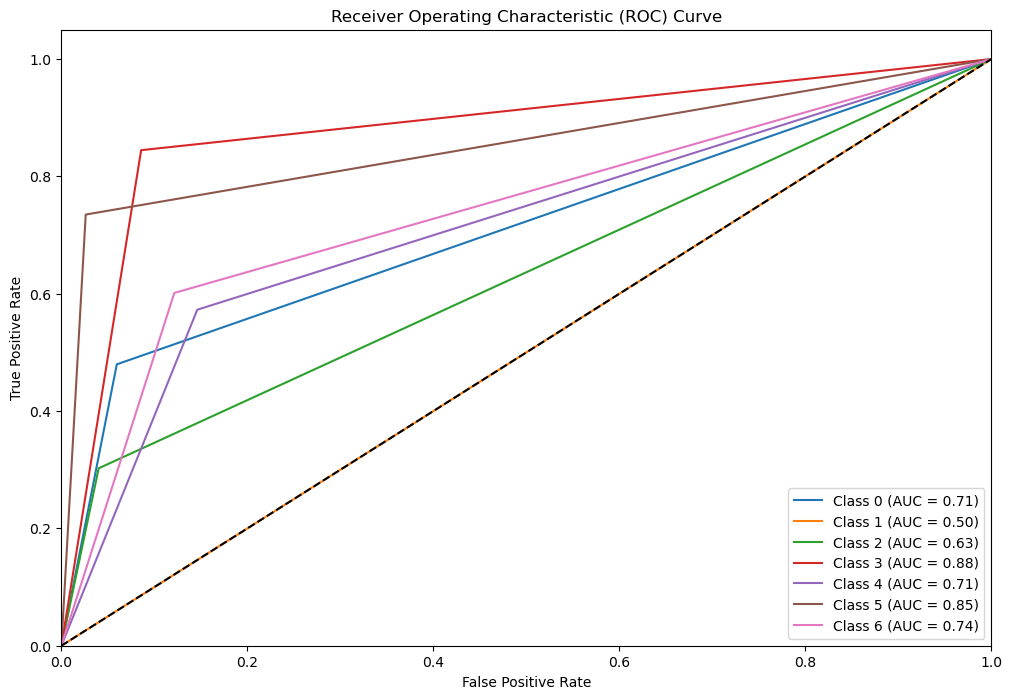

In [74]:
def plot_roc_curve(test_labels, pred_test_labels, num_classes):
    """Plot ROC curve for each class"""
    fpr = {}
    tpr = {}
    roc_auc = {}

    test_labels_binarized = label_binarize(test_labels.argmax(axis=1), classes=range(num_classes))
    pred_test_labels_binarized = label_binarize(pred_test_labels.argmax(axis=1), classes=range(num_classes))

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(test_labels_binarized[:, i], pred_test_labels_binarized[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(12, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# ROC eğrisi çizme
plot_roc_curve(test_labels, pred_test_labels, num_classes=len(emotions))

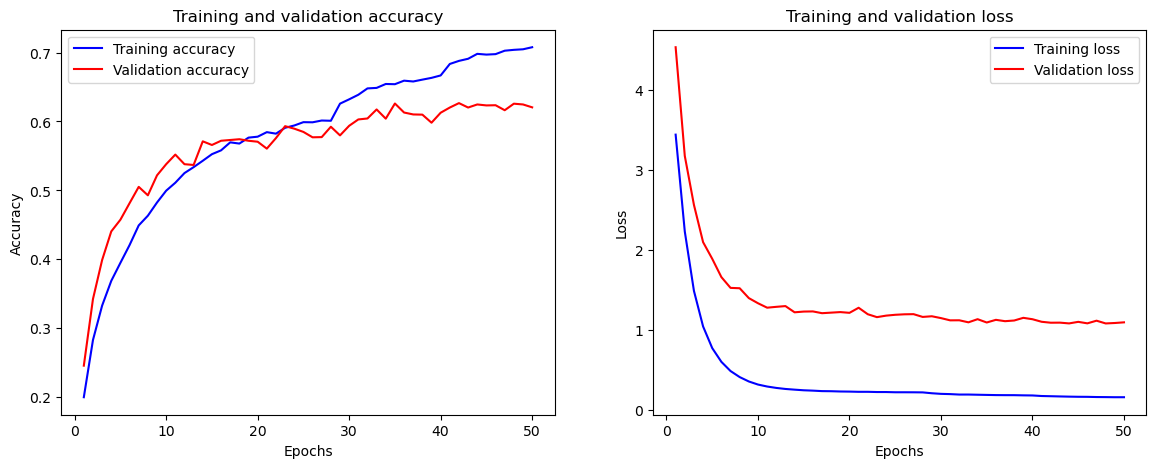

In [58]:
def plot_training_history(history):
    """Plot training and validation accuracy and loss"""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Eğitim ve doğrulama geçmişini çizme
plot_training_history(history)

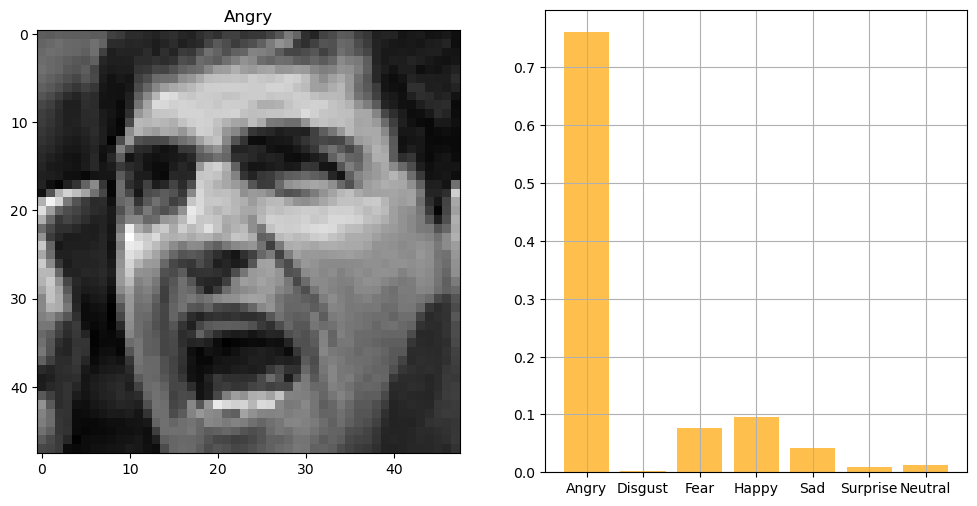

In [59]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 151)

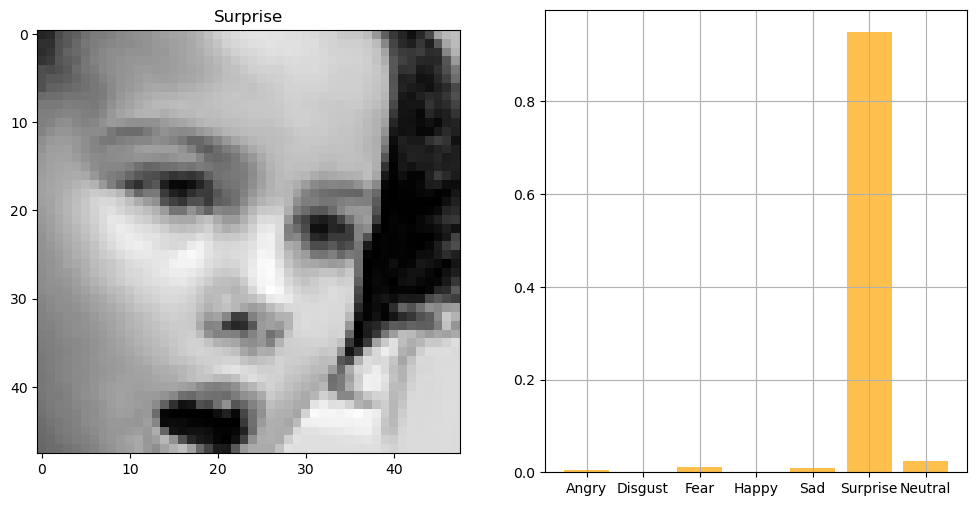

In [60]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 46)

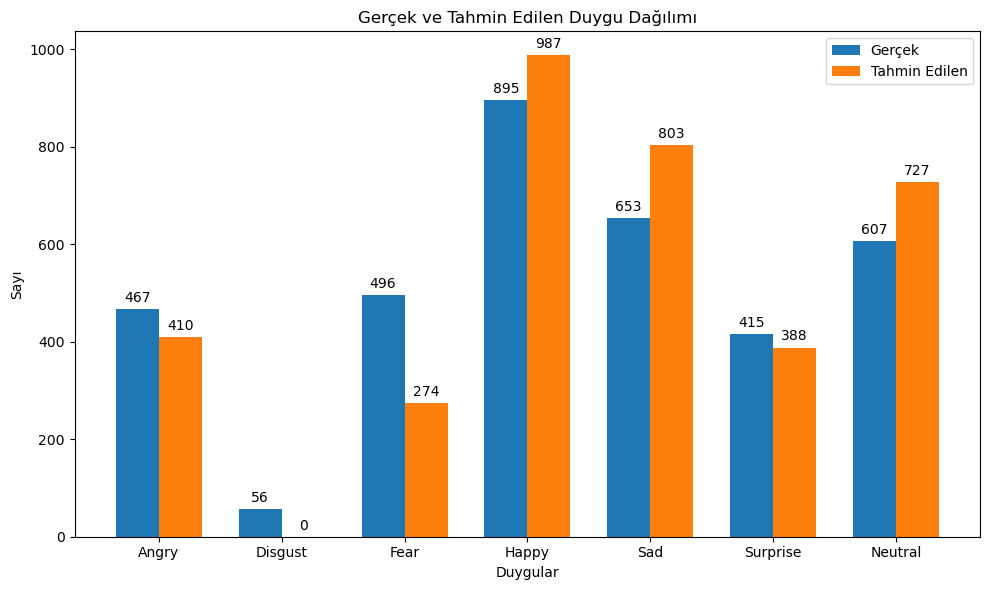

In [61]:
def plot_emotion_distribution(image_label, pred_labels, emotions):
    # Gerçek duyguların sayısını hesapla
    true_counts = {emotion: 0 for emotion in emotions.values()}
    for label in image_label:
        true_counts[emotions[label]] += 1

    # Tahmin edilen duyguların sayısını hesapla
    pred_counts = {emotion: 0 for emotion in emotions.values()}
    for label in pred_labels:
        pred_counts[emotions[np.argmax(label)]] += 1

    # Duygu adlarını ve sayılarını al
    labels = list(true_counts.keys())
    true_values = list(true_counts.values())
    pred_values = list(pred_counts.values())

    # Bar plot oluştur
    x = np.arange(len(labels))  # X eksenindeki konumlar
    width = 0.35  # Çubuk genişliği

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, true_values, width, label='Gerçek')
    rects2 = ax.bar(x + width/2, pred_values, width, label='Tahmin Edilen')

    # Eksen ve etiket ayarları
    ax.set_xlabel('Duygular')
    ax.set_ylabel('Sayı')
    ax.set_title('Gerçek ve Tahmin Edilen Duygu Dağılımı')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Çubukların üzerine değerleri ekleme
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 nokta yukarıya metni taşı
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()

# Fonksiyonu çağırma örneği
plot_emotion_distribution(test_image_label, pred_test_labels, emotions)


In [62]:
# Test ve tahmin etiketlerinden ilk 10 tanesini yazdırarak kontrol edelim
print("Test etiketleri (ilk 10):", test_labels.argmax(axis=1)[:10])
print("Tahmin etiketleri (ilk 10):", pred_test_labels.argmax(axis=1)[:10])

# Karmaşıklık matrisini yazdırarak kontrol edelim
cm = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1))
print("Karmaşıklık Matrisi:\n", cm)

Test etiketleri (ilk 10): [0 1 4 6 3 3 2 0 2 0]
Tahmin etiketleri (ilk 10): [0 3 0 4 3 3 4 4 4 2]
Karmaşıklık Matrisi:
 [[224   0  27  45 100  10  61]
 [ 23   0   5   4  15   1   8]
 [ 50   0 150  33 144  43  76]
 [ 15   0  15 756  35  17  57]
 [ 54   0  35  53 374   6 131]
 [ 13   0  20  31  17 305  29]
 [ 31   0  22  65 118   6 365]]


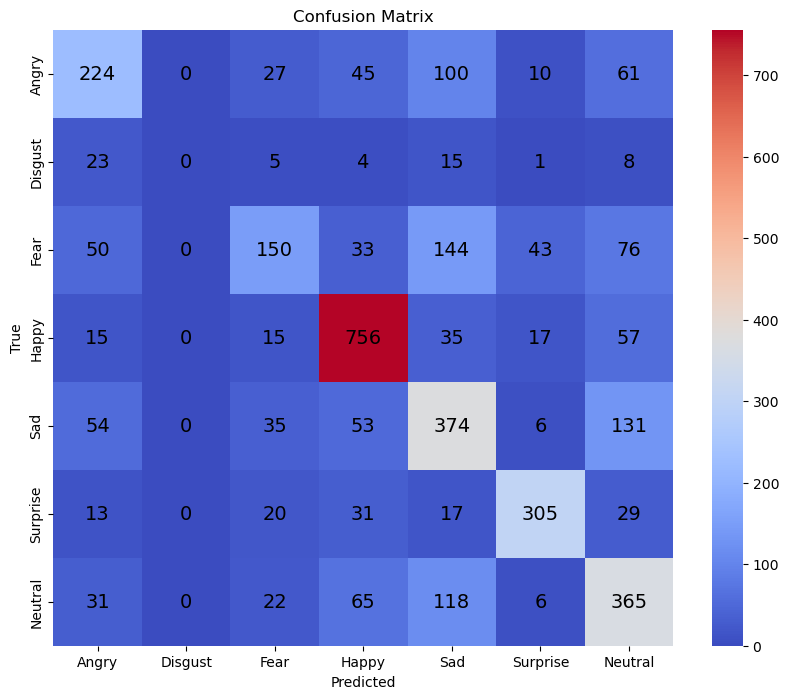

In [63]:
def plot_confusion_matrix_with_manual_annotations(test_labels, pred_test_labels, emotions):
    """Plot confusion matrix with manual annotations"""
    cm = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, cmap='coolwarm', xticklabels=emotions.values(), yticklabels=emotions.values())
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j + 0.5, i + 0.5, str(cm[i, j]), ha='center', va='center', color='black', fontsize=14)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Karmaşıklık matrisi çizme
plot_confusion_matrix_with_manual_annotations(test_labels, pred_test_labels, emotions)

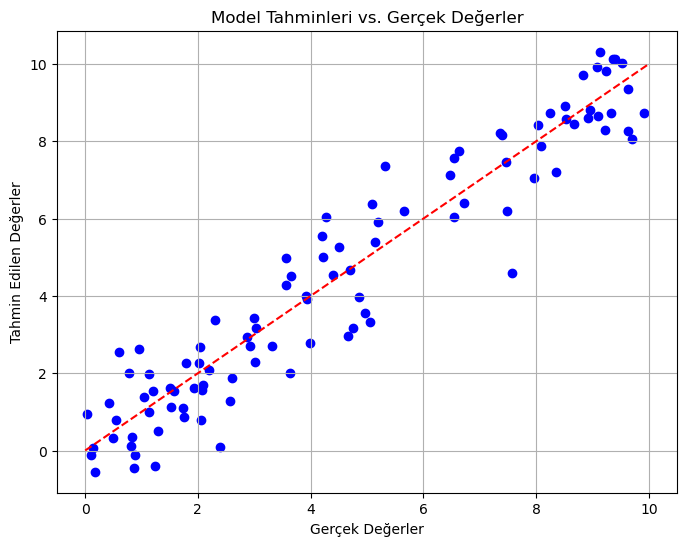

/Users/berkaybakac/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


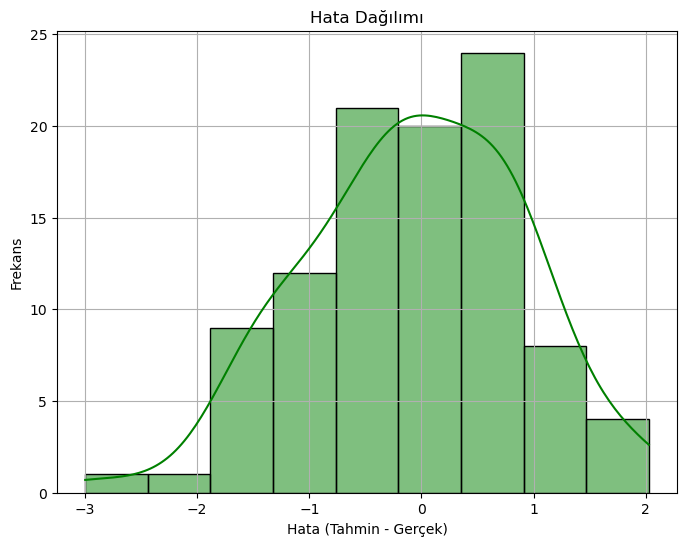

In [64]:
# Örnek veri oluşturalım
gercek_degerler = np.random.rand(100) * 10  # Gerçek değerler
tahmin_degerler = gercek_degerler + np.random.randn(100)  # Modelin tahmin ettiği değerler (gerçek değerlerin üzerine gürültü ekleme)

# Gerçek ve tahmin edilen değerler arasındaki ilişkiyi gösteren bir scatter plot (dağılım grafiği) oluşturalım
plt.figure(figsize=(8, 6))
plt.scatter(gercek_degerler, tahmin_degerler, color='blue')
plt.plot([0, 10], [0, 10], color='red', linestyle='--')  # 45 derecelik doğru
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Edilen Değerler')
plt.title('Model Tahminleri vs. Gerçek Değerler')
plt.grid(True)
plt.show()

# Hata dağılımını gösteren bir histogram oluşturalım
hatalar = tahmin_degerler - gercek_degerler
plt.figure(figsize=(8, 6))
sns.histplot(hatalar, kde=True, color='green')
plt.xlabel('Hata (Tahmin - Gerçek)')
plt.ylabel('Frekans')
plt.title('Hata Dağılımı')
plt.grid(True)
plt.show()


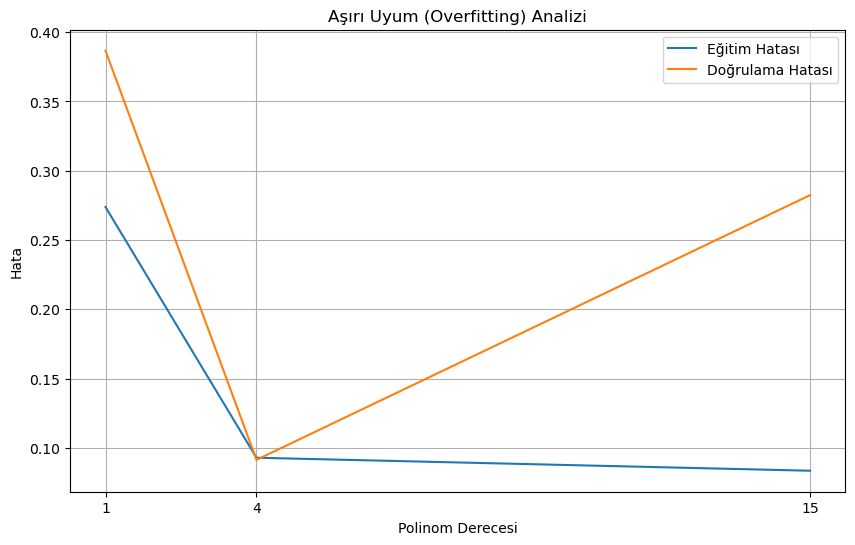

In [65]:

# Örnek veri oluşturalım
np.random.seed(0)
X = 2 * np.pi * np.random.rand(100, 1)
y = np.sin(X) + 0.3 * np.random.randn(100, 1)

# Veriyi eğitim ve doğrulama setlerine ayıralım
X_train, X_val = X[:80], X[80:]
y_train, y_val = y[:80], y[80:]

degrees = [1, 4, 15]  # Farklı polinom dereceleri

# Her bir polinom derecesi için eğitim ve doğrulama hatasını saklayacak listeler oluşturalım
train_errors = []
val_errors = []

for degree in degrees:
    # Modeli eğitelim
    coeffs = np.polyfit(X_train.flatten(), y_train.flatten(), degree)
    p = np.poly1d(coeffs)
    
    # Eğitim ve doğrulama setlerinde hata hesaplayalım
    train_error = np.mean((p(X_train.flatten()) - y_train.flatten()) ** 2)
    val_error = np.mean((p(X_val.flatten()) - y_val.flatten()) ** 2)
    
    train_errors.append(train_error)
    val_errors.append(val_error)

# Hata grafiğini çizelim
plt.figure(figsize=(10, 6))
plt.plot(degrees, train_errors, label='Eğitim Hatası')
plt.plot(degrees, val_errors, label='Doğrulama Hatası')
plt.xlabel('Polinom Derecesi')
plt.ylabel('Hata')
plt.title('Aşırı Uyum (Overfitting) Analizi')
plt.xticks(degrees)
plt.legend()
plt.grid(True)
plt.show()


In [66]:
# Eğitilen modelinizi kaydedin
model.save('facial_recognition_model')

# Modeli TensorFlow Lite formatına dönüştürün
converter = tf.lite.TFLiteConverter.from_saved_model('facial_recognition_model')
tflite_model = converter.convert()

# Dönüştürülen modeli dosyaya kaydedin
with open('facial_recognition_model.tflite', 'wb') as f:
    f.write(tflite_model)

2024-05-20 03:08:27.490884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,23,23,32]
	 [[{{node inputs}}]]
2024-05-20 03:08:27.500056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,10,10,64]
	 [[{{node inputs}}]]
2024-05-20 03:08:27.505548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,4,4,128]
	 [[{{node inputs}}]]
20

INFO:tensorflow:Assets written to: facial_recognition_model/assets


INFO:tensorflow:Assets written to: facial_recognition_model/assets
2024-05-20 03:08:29.802854: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-05-20 03:08:29.803086: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-05-20 03:08:29.805168: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: facial_recognition_model
2024-05-20 03:08:29.807438: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-05-20 03:08:29.807443: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: facial_recognition_model
2024-05-20 03:08:29.814273: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2024-05-20 03:08:29.816623: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-05-20 03:08:29.926645: I tensorflow/cc/saved_model/loader.cc:21

In [67]:
from PIL import Image

# Define the emotion titles based on the class indices
emotion_titles = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

def preprocess_image_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):  # Assuming images are JPEG or PNG format
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path).convert('L')  # Convert to grayscale
            image = image.resize((48, 48))  # Resize to model input size
            image = np.array(image)  # Convert to numpy array
            # Reshape to match Conv2D input shape (batch_size, height, width, channels)
            image = np.expand_dims(image, axis=-1)  # Add channel dimension
            images.append(image)
    return np.array(images)

def predict_emotions_from_folder(folder_path, model):
    images = preprocess_image_from_folder(folder_path)
    predictions = model.predict(images)
    emotion_classes = np.argmax(predictions, axis=1)
    emotion_titles_predicted = [emotion_titles[class_index] for class_index in emotion_classes]
    return emotion_titles_predicted

In [70]:
emotion_titles_predicted = predict_emotions_from_folder('test1', model)
print(f'Predicted emotion titles: {emotion_titles_predicted}')

1/1 [==============================] - 0s 16ms/step
Predicted emotion titles: ['Surprise']
